In [1]:
# this is a necessary library that, i installed here, which was causing issue in local environment
# so want to install it whenever run this notebook, even if it's already installed.
!pip install SimpleITK 

In [2]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import SimpleITK as stk
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage import measure

In [3]:
root = "/kaggle/input/luna16/"
target_root = "//kaggle/input/luna16/processed/"

In [4]:
import pandas as pd
from glob import glob

# Base path for the LUNA16 dataset
base_path = '/kaggle/input/luna16/'

# Loop through the subsets you want to read, adjust the range as needed
for subset in range(0,4):  # This will loop through subset0 and subset1
    # Update the path for glob to match the directory structure
    file_list = glob(f"{base_path}/subset{subset}/subset{subset}/*.mhd")
    
    # Print out the count of files for each subset
    print(f"Files in subset{subset} Count:", len(file_list))

# Read the annotations file if it's located directly under the luna16 folder
annotations_df = pd.read_csv(f"{base_path}/annotations.csv")
print("Annotations DF Count:", len(annotations_df))
annotations_df.head()


Files in subset0 Count: 89
Files in subset1 Count: 89
Files in subset2 Count: 89
Files in subset3 Count: 89
Annotations DF Count: 1186


,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


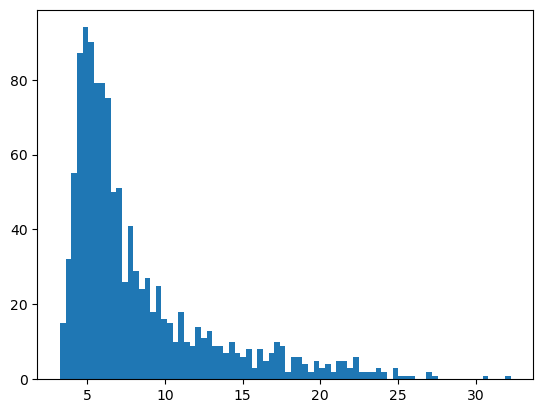

In [5]:
d = annotations_df['diameter_mm'].values
fig = plt.hist(d, bins=80)

In [6]:
def get_filename(file_list, file):
    for f in file_list:
        if file in f:
            return f

In [7]:
annotations_df["filename"] = annotations_df["seriesuid"].map(lambda file: get_filename(file_list, file))
annotations_df = annotations_df.dropna()
annotations_df = annotations_df[annotations_df['diameter_mm']>=3.9]     # Excluding nodules with diameter less than 3.9mm
print(len(annotations_df))

114


In [8]:
annotations_df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,filename
7,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.509646,54.957219,-150.346423,10.362321,/kaggle/input/luna16//subset3/subset3/1.3.6.1....
11,1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...,2.263816,33.526418,-170.636950,7.168542,/kaggle/input/luna16//subset3/subset3/1.3.6.1....
71,1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347...,49.312936,-63.215210,-118.799562,22.133220,/kaggle/input/luna16//subset3/subset3/1.3.6.1....
85,1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451...,-129.054725,-12.238555,-79.497885,21.827953,/kaggle/input/luna16//subset3/subset3/1.3.6.1....
99,1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596...,44.016476,-7.920203,-249.687665,7.604463,/kaggle/input/luna16//subset3/subset3/1.3.6.1....


In [9]:
def load_mhd(file):
    mhdimage = stk.ReadImage(file)
    ct_scan = stk.GetArrayFromImage(mhdimage)
    origin = np.array(list(mhdimage.GetOrigin()))
    space = np.array(list(mhdimage.GetSpacing()))
    return ct_scan, origin, space

In [10]:
def make_mask(img, center, diam):
    mask = np.zeros_like(img, dtype=np.uint8)
    mask = cv2.circle(mask, (abs(int(center[0])),abs(int(center[1]))),int(abs(diam//2)), 255, -1)
    return mask

In [11]:
annotations_df_new = pd.read_csv("/kaggle/input/luna-lung-cancer-dataset/annotations.csv")
annotations_df_new

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150
...,...,...,...,...,...
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-160.856298,-28.560349,-269.168728,5.053694
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-102.189570,-73.865766,-220.536241,4.556101
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-37.535409,64.041949,-127.687101,4.357368
1184,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,43.196112,74.438486,-200.523314,4.277203


In [12]:
n_neighbour = 4

In [13]:
target_root = '/kaggle/working/'
import os
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
# from your_module import load_mhd, make_mask  # Make sure to import your actual function
from skimage import measure
import cv2

# Define your target root directory
target_root = '/kaggle/working/'

# CLAHE filter for enhancing the contrast of an image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Define the directories for saving output
nodule_mask_dir = os.path.join(target_root, "nodule_mask/")
lungs_roi_dir = os.path.join(target_root, "lungs_roi/")

# Create the directories if they do not exist
os.makedirs(nodule_mask_dir, exist_ok=True)
os.makedirs(lungs_roi_dir, exist_ok=True)

In [14]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # CLAHE(Contrast Limited Adaptive Histogram Equalization) filter for enhancing the contrast of an image
# Import necessary library
import os

# Define the directories for saving output
nodule_mask_dir = os.path.join(target_root, "nodule_mask/")
lungs_roi_dir = os.path.join(target_root, "lungs_roi/")

# Create the directories if they do not exist
os.makedirs(nodule_mask_dir, exist_ok=True)
os.makedirs(lungs_roi_dir, exist_ok=True)
# Iterating over all the files in the subset
for i,file in tqdm(enumerate(np.unique(annotations_df['filename'].values))):
    annotations = annotations_df[annotations_df["filename"]==file]
    ct, origin, space = load_mhd(file)      # Loading the CT scan
    num_z, height, width = ct.shape
    ct_norm = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)   # Normalizing the CT scan
    for idx, row in annotations.iterrows():
        node_x = int(row["coordX"])     # X coordinate of the nodule
        node_y = int(row["coordY"])     # Y coordinate of the nodule
        node_z = int(row["coordZ"])     # Z coordinate of the nodule
        diam = int(row["diameter_mm"])  # Diameter of the nodule

        center = np.array([node_x, node_y, node_z])   # nodule center (x,y,z)
        v_center = np.rint((center-origin)/space)   # nodule center in voxel space (still x,y,z ordering)
        v_diam = int(diam/space[0])+5       # Diameter of the nodule in voxel space

        img_norm_neighbours = []
        img_norm_improved_neighbours = []
        mask_neighbours = []
        img_norm = None
        img_norm_improved = None
        mask = None

        if 18<v_diam<22:              # If nodule diameter is of medium size the take two neighbour slides into consideration
            n_neighbour = 2

        min_i = max(0,(int(v_center[2])-n_neighbour))
        max_i = min((int(v_center[2])+n_neighbour),(num_z-1))
        n = max_i-min_i

        img_norm = ct_norm[int(v_center[2]),:,:]    # a slice of the CT scan containing the nodule
        img_norm = cv2.resize(img_norm, (512,512))  # Resizing the CT scan to 512x512
        img_norm_improved = clahe.apply(img_norm.astype(np.uint8))  # Applying CLAHE filter to the image
        mask = make_mask(img_norm, v_center, v_diam)    # Creating a mask of the nodule

        if v_diam>18:      # If the nodule is too big, we will also take neighboring slices
            for i in range(min_i, max_i+1):
                if i==int(v_center[2]):
                    continue

                im_n = ct_norm[i,:,:]
                im_n = cv2.resize(im_n, (512,512))
                im_n_improved = clahe.apply(im_n.astype(np.uint8))
                dia = int(2*abs(v_center[2]-i))    # Decrease mask diameter because nodule diameter decrease as we move away from its center
                msk = make_mask(im_n, v_center, v_diam-dia)
                img_norm_neighbours.append(im_n)
                img_norm_improved_neighbours.append(im_n_improved)
                mask_neighbours.append(msk)
            assert len(img_norm_neighbours)==len(img_norm_improved_neighbours)==len(mask_neighbours)==n

        # Calculating the threshold value for extracting the nodule mask using binary thresholding
        mask = cv2.bitwise_and(img_norm, img_norm, mask=cv2.dilate(mask,kernel=np.ones((5,5))))
        pts = mask[mask>0]
        kmeans2 = KMeans(n_clusters=2).fit(np.reshape(pts,(len(pts),1)))
        centroids2 = sorted(kmeans2.cluster_centers_.flatten())
        threshold2 = np.mean(centroids2)

        _, mask = cv2.threshold(mask, threshold2, 255, cv2.THRESH_BINARY)


        if v_diam>18:
            for i in range(n):
                mask_neighbours[i] = cv2.bitwise_and(img_norm_neighbours[i], img_norm_neighbours[i], mask=cv2.dilate(mask_neighbours[i],kernel=np.ones((5,5))))
                _, mask_neighbours[i] = cv2.threshold(mask_neighbours[i], threshold2, 255, cv2.THRESH_BINARY)


        # Calculating the threshold value to segment the lungs from CT scan slices using binary thresholding
        centeral_area = img_norm[100:400, 100:400]
        kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
        centroids = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centroids)

        # Steps to segment the lungs from CT scan slices
        ret, lung_roi = cv2.threshold(img_norm, threshold, 255, cv2.THRESH_BINARY_INV)
        lung_roi = cv2.erode(lung_roi, kernel=np.ones([4,4]))
        lung_roi = cv2.dilate(lung_roi, kernel=np.ones([13,13]))
        lung_roi = cv2.erode(lung_roi, kernel=np.ones([8,8]))

        labels = measure.label(lung_roi)        # Labelling different regions in the image
        regions = measure.regionprops(labels)   # Extracting the properties of the regions
        good_labels = []
        for prop in regions:        # Filtering the regions that are not too close to the edges
            B = prop.bbox           # Regions that are too close to the edges are outside regions of lungs
            if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
                good_labels.append(prop.label)
        lung_roi_mask = np.zeros_like(labels)
        for N in good_labels:
            lung_roi_mask = lung_roi_mask + np.where(labels == N, 1, 0)

        # Steps to get proper segmentation of the lungs without noise and holes
        contours, hirearchy = cv2.findContours(lung_roi_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        external_contours = np.zeros(lung_roi_mask.shape)
        for i in range(len(contours)):
            if hirearchy[0][i][3] == -1:  #External Contours
                area = cv2.contourArea(contours[i])
                if area>518.0:
                    cv2.drawContours(external_contours,contours,i,(1,1,1),-1)
        external_contours = cv2.dilate(external_contours, kernel=np.ones([4,4]))

        external_contours = cv2.bitwise_not(external_contours.astype(np.uint8))
        external_contours = cv2.erode(external_contours, kernel=np.ones((7,7)))
        external_contours = cv2.bitwise_not(external_contours)
        external_contours = cv2.dilate(external_contours, kernel=np.ones((12,12)))
        external_contours = cv2.erode(external_contours, kernel=np.ones((12,12)))

        img_norm_improved = img_norm_improved.astype(np.uint8)
        external_contours = external_contours.astype(np.uint8)      # Final segmentated lungs mask
        extracted_lungs = cv2.bitwise_and(img_norm_improved, img_norm_improved, mask=external_contours)

        mask = mask.astype(np.uint8)
        np.save(os.path.join("/kaggle/working/"+"nodule_mask/", f"masks_{subset}_{i}_{idx}.npy"), mask)
        np.save(os.path.join("/kaggle/working/"+"lungs_roi/", f"lungs_{subset}_{i}_{idx}.npy"), extracted_lungs)

        extracted_lungs_neighbours = [None]*n

        if v_diam>18:
            for i in range(n):
                img_norm_improved_neighbours[i] = img_norm_improved_neighbours[i].astype(np.uint8)
                extracted_lungs_neighbours[i] = cv2.bitwise_and(img_norm_improved_neighbours[i], img_norm_improved_neighbours[i], mask=external_contours)
                mask_neighbours[i] = mask_neighbours[i].astype(np.uint8)
                np.save(os.path.join("/kaggle/working/"+"nodule_mask/", f"masks_{subset}_{i}_{idx}_{i}.npy"), mask_neighbours[i])
                np.save(os.path.join("/kaggle/working/"+"lungs_roi/", f"lungs_{subset}_{i}_{idx}_{i}.npy"), extracted_lungs_neighbours[i])

65it [01:49,  1.68s/it]


In [15]:
# Modelisation

After preparing my data, segmenting the lung areas, and saving the nodule masks along with the lung regions of interest (ROI), the next step is to build and train a deep learning model for segmentation or classification (cancer detection) based on our objectives. 

Here is how to proceed with modeling, training, and evaluating my model:

#  Data preparation.

##### Step 1: Load the images and masks.


The lung-extracted images (lungs_roi) and nodule masks (nodule_mask) are stored in .npy files. Now, we need to load them and associate them with the corresponding labels.

Visualizing both lung region images (ROI - Region of Interest) and nodule masks for multiple cases helps you understand where nodules are located and potentially whether these nodules can be indicative of cancer.

- The reason we use masks in this context is to specifically identify regions of interest (nodules) in lung images.
- A mask indicates the exact location of the nodule in the image, which is crucial for cancer analysis and detection. Deep learning models can use these masks to learn how to distinguish potential nodules from the rest of the lung tissue.

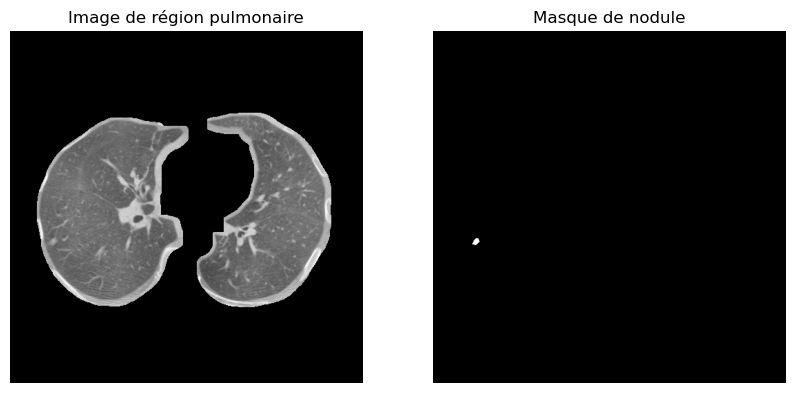

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple de chemin vers une image et son masque
image_path = '/kaggle/working/lungs_roi/lungs_3_11_736.npy'  # Mettez à jour avec votre chemin réel
mask_path = '/kaggle/working/nodule_mask/masks_3_11_736.npy'  # Mettez à jour avec votre chemin réel

# Chargement de l'image et du masque
image = np.load(image_path)
mask = np.load(mask_path)

# Affichage de l'image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Image de région pulmonaire')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Masque de nodule')
plt.axis('off')

plt.show()



This script loads and displays a specified number of images and masks.

- Visualizing these images helps you understand how nodules are represented in the data and how the masks identify these nodules.
- It is an essential step to check the quality of your preprocessing and to understand the data on which our model will be trained.

=> Lung segmentation (extraction of ROIs) and nodule masks are two key steps to isolate relevant areas for analysis and reduce noise and distractions in the images, allowing the model to focus only on the important parts.

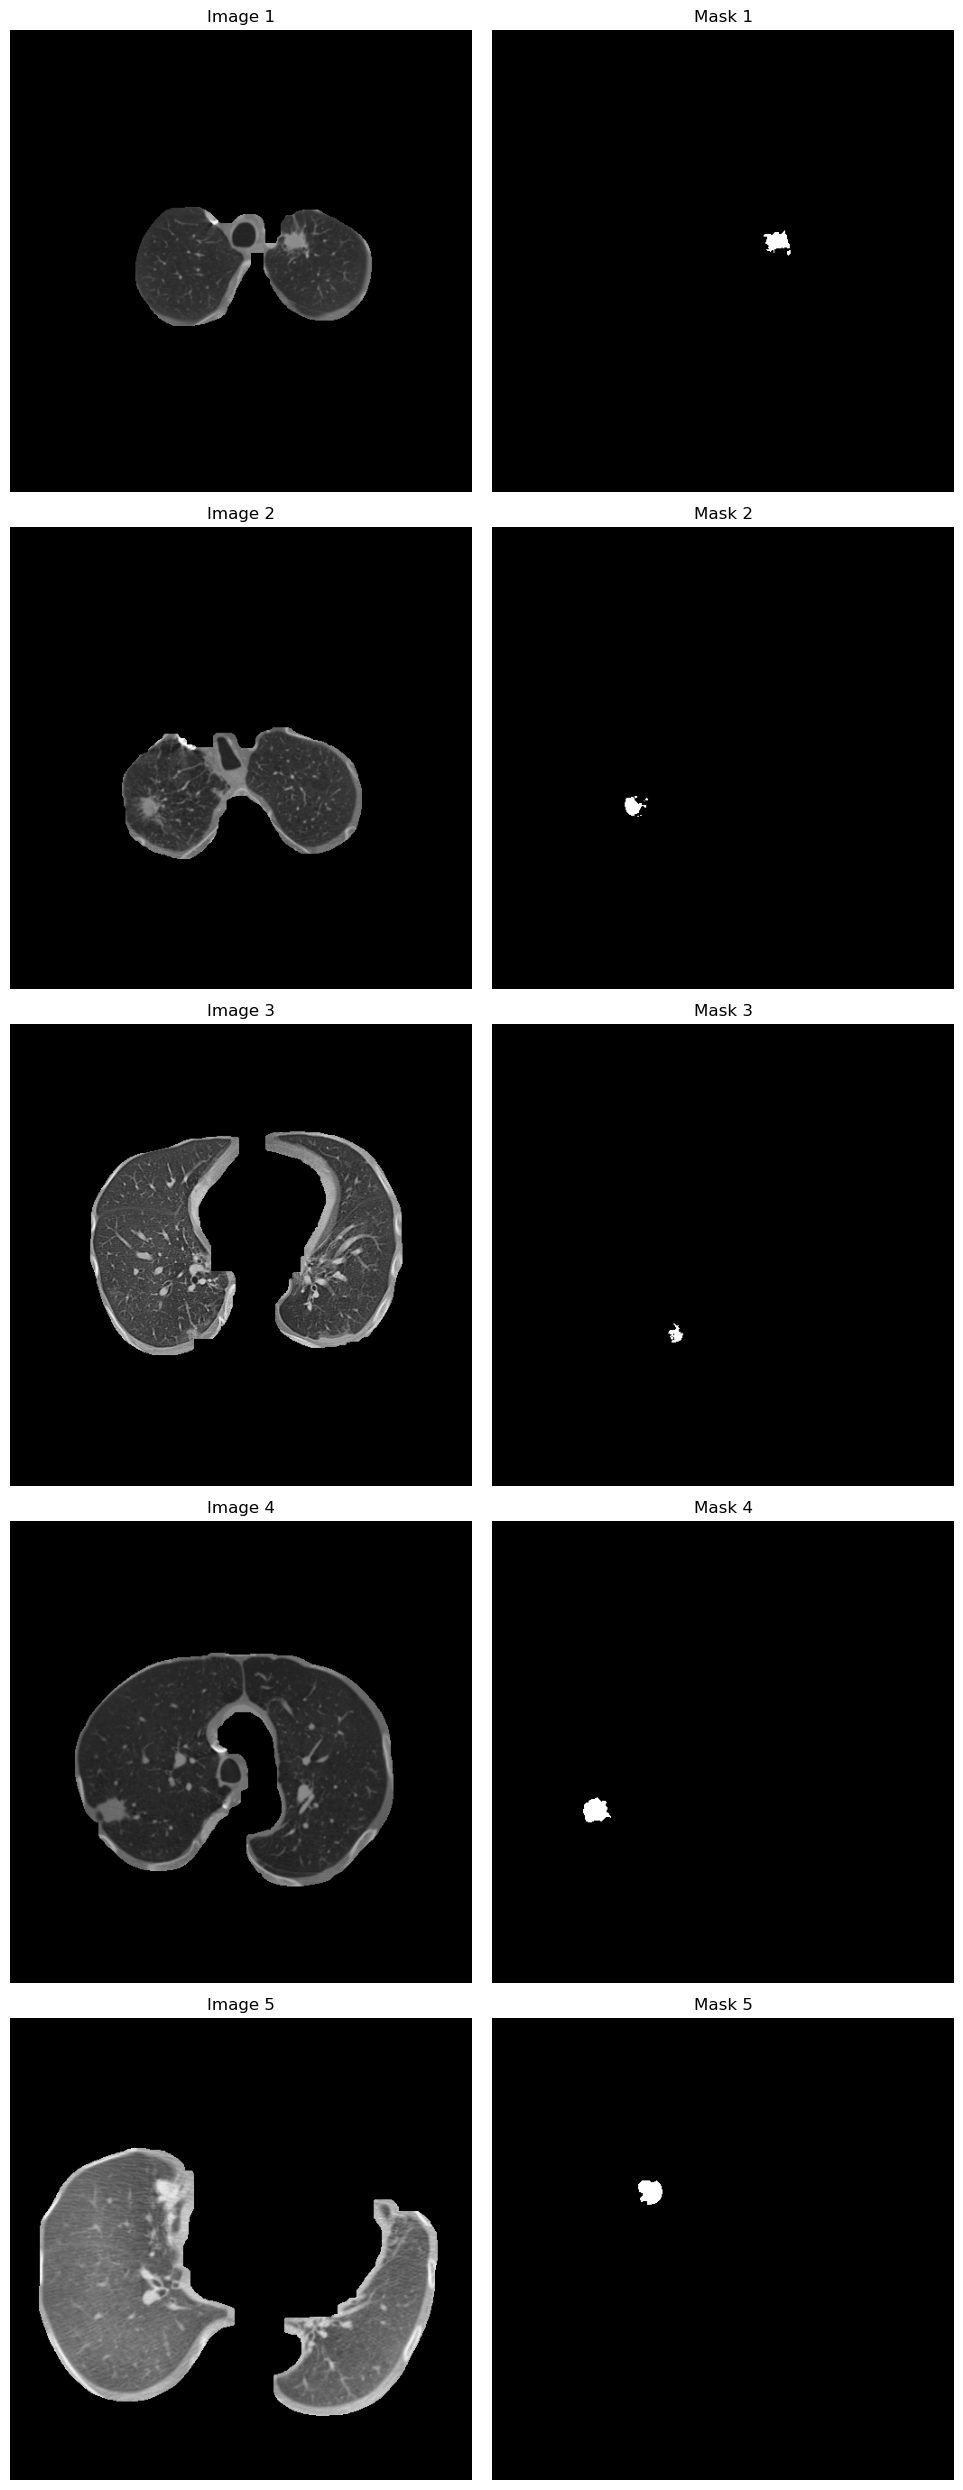

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Paths to the directories containing lung-extracted images and nodule masks
lungs_roi_dir = "/kaggle/working/lungs_roi/"
nodule_mask_dir = "/kaggle/working/nodule_mask/"

# Obtention des chemins de fichiers
lungs_images_paths = glob(lungs_roi_dir + "*.npy")
nodule_masks_paths = glob(nodule_mask_dir + "*.npy")

# Get file paths
lungs_images_paths.sort()
nodule_masks_paths.sort()

# Ensure paths are sorted to match images with their masks
n_images_to_show = 5  # ou len(lungs_images_paths) pour afficher toutes les images

plt.figure(figsize=(10, 5 * n_images_to_show))

for i in range(min(n_images_to_show, len(lungs_images_paths))):
    # Define how many images you want to visualize
    image = np.load(lungs_images_paths[i])
    mask = np.load(nodule_masks_paths[i])
    
    plt.subplot(n_images_to_show, 2, 2*i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(n_images_to_show, 2, 2*i+2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


- Visualization of these images helps you understand how nodules are represented in the data and how the masks identify these nodules.

### Step 2: Preparation of X and y

- X: The loaded images (lungs_roi) serve as input data for our model.
- y: The nodule masks, after processing, act as labels indicating the presence or absence of nodules.
- Normalization: The images are normalized to have values between 0 and 1, which is a standard practice to enhance the training of deep learning models.
- Creation of y labels: We have defined y in a binary manner, where 1 indicates the presence of a nodule, and 0 indicates its absence. The logic behind this creation depends on the presence of non-zero pixels in the image, signifying the presence of nodules.

In [18]:
import numpy as np
from glob import glob

# Paths to the directories containing lung-extracted images and nodule masks
lungs_roi_dir = "/kaggle/working/lungs_roi/"
nodule_mask_dir = "/kaggle/working/nodule_mask/"

# Load images (X) and masks (y)
lungs_images_paths = glob(lungs_roi_dir + "*.npy")
nodule_masks_paths = glob(nodule_mask_dir + "*.npy")

# Ensure paths are sorted so that each image matches its mask
lungs_images_paths.sort()
nodule_masks_paths.sort()

X = np.array([np.load(path) for path in lungs_images_paths])
y = np.array([np.load(path) for path in nodule_masks_paths])

# Normalize the images
X = X / 255.0

# For labels, decide on the logic based on the presence or absence of a nodule:
# Here, a simplified example where y is binary: 1 if a nodule is present, 0 otherwise.
y = np.array([1 if np.any(mask) else 0 for mask in y])

### Step 3: Splitting into training, validation, and test sets



In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [20]:
import os
import numpy as np

# For images
image_files = os.listdir('/kaggle/working/lungs_roi/')
print("Number of images:", len(image_files))

# For masks
mask_files = os.listdir('/kaggle/working/nodule_mask/')
print("Number of masks:", len(mask_files))

# Check that each image has its corresponding mask
assert len(image_files) == len(mask_files), "The number of images and masks do not match."


Number of images: 226
Number of masks: 226


# Augmentation

In [21]:
import os

# Paths to directories where your image and mask files are located
images_dir = '/kaggle/working/lungs_roi/'
masks_dir = '/kaggle/working/nodule_mask/'

# List all files in the directories
image_files = os.listdir(images_dir)
mask_files = os.listdir(masks_dir)

# Ensure that for each image, there is a corresponding mask
for image_file in image_files:
    # Remove the extension and any potential suffix to get the base identifier
    base_id = image_file.split('.')[0].rsplit('_', 1)[0]
    corresponding_mask = base_id + '_mask.npy'  # This is just an example, adjust according to your file names
    if corresponding_mask not in mask_files:
        print(f"Corresponding mask not found for the image: {image_file}")


Corresponding mask not found for the image: lungs_3_2_1120_2.npy
Corresponding mask not found for the image: lungs_3_7_176.npy
Corresponding mask not found for the image: lungs_3_9_178.npy
Corresponding mask not found for the image: lungs_3_5_1043.npy
Corresponding mask not found for the image: lungs_3_9_884.npy
Corresponding mask not found for the image: lungs_3_2_1043_2.npy
Corresponding mask not found for the image: lungs_3_3_1179.npy
Corresponding mask not found for the image: lungs_3_2_1178_2.npy
Corresponding mask not found for the image: lungs_3_3_11.npy
Corresponding mask not found for the image: lungs_3_3_1107.npy
Corresponding mask not found for the image: lungs_3_0_1004_0.npy
Corresponding mask not found for the image: lungs_3_3_719_3.npy
Corresponding mask not found for the image: lungs_3_3_133_3.npy
Corresponding mask not found for the image: lungs_3_3_782.npy
Corresponding mask not found for the image: lungs_3_1_1177_1.npy
Corresponding mask not found for the image: lungs

#  Modelisation simple 

Nous allons utiliser un modèle simple de CNN (réseau de neurones convolutifs) pour la classification binaire des nodules (présence de cancer ou non). 



In [22]:
from tensorflow.keras import layers, models, callbacks

def build_model(input_shape):
    """
        It is a simple convolutional network
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Define the input shape based on your data
input_shape = (512, 512, 1)  # Adjust according to your data
model = build_model(input_shape)

# Callback for early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 64)     2

# Training the model


In [23]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_data=(X_val, y_val), callbacks = early_stopping)


Epoch 1/100


2024-03-10 12:56:03.354051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 13s 376ms/step - loss: 1.0708 - accuracy: 0.5111 - val_loss: 2.8100e-08 - val_accuracy: 1.0000
Epoch 2/100
9/9 [==============================] - 2s 202ms/step - loss: 0.8709 - accuracy: 0.4889 - val_loss: 6.9060e-24 - val_accuracy: 1.0000
Epoch 3/100
9/9 [==============================] - 2s 202ms/step - loss: 0.7345 - accuracy: 0.6296 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
9/9 [==============================] - 1s 161ms/step - loss: 0.6537 - accuracy: 0.6963 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
9/9 [==============================] - 1s 162ms/step - loss: 0.6125 - accuracy: 0.6667 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
9/9 [==============================] - 1s 161ms/step - loss: 0.4958 - accuracy: 0.7630 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
9/9 [==============================] - 1s 162ms/step - loss: 0.4530 - accuracy: 0.7852 - val_loss: 0.0000e+00 - val_accuracy: 1.0

## Évaluation du modèle


In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")


2/2 [==============================] - 1s 384ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test accuracy: 1.000


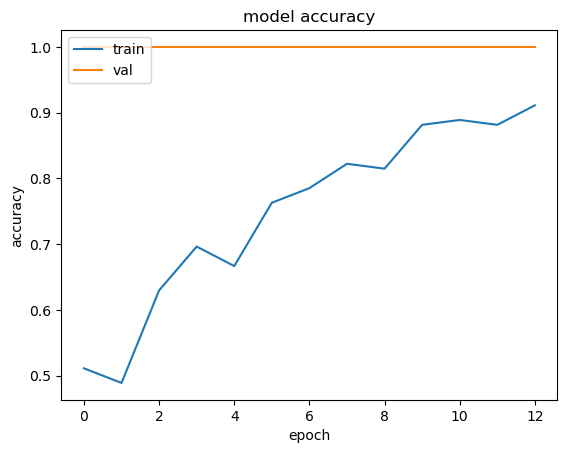

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.ylim([0.95,1])
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("resnet_accuracy98.png")
plt.show()

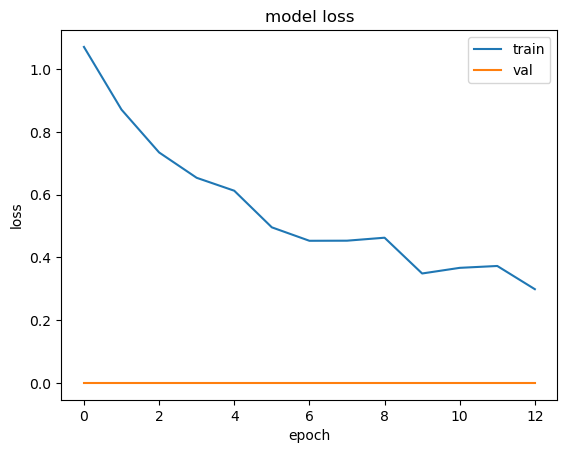

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim([0.05,0.3])
plt.legend(['train', 'val'], loc='upper right')
plt.savefig("resnet_loss.png")
plt.show()

## Utilisation du modèle pour la prédiction


In [27]:
predictions = model.predict(X_test)

2/2 [==============================] - 0s 35ms/step


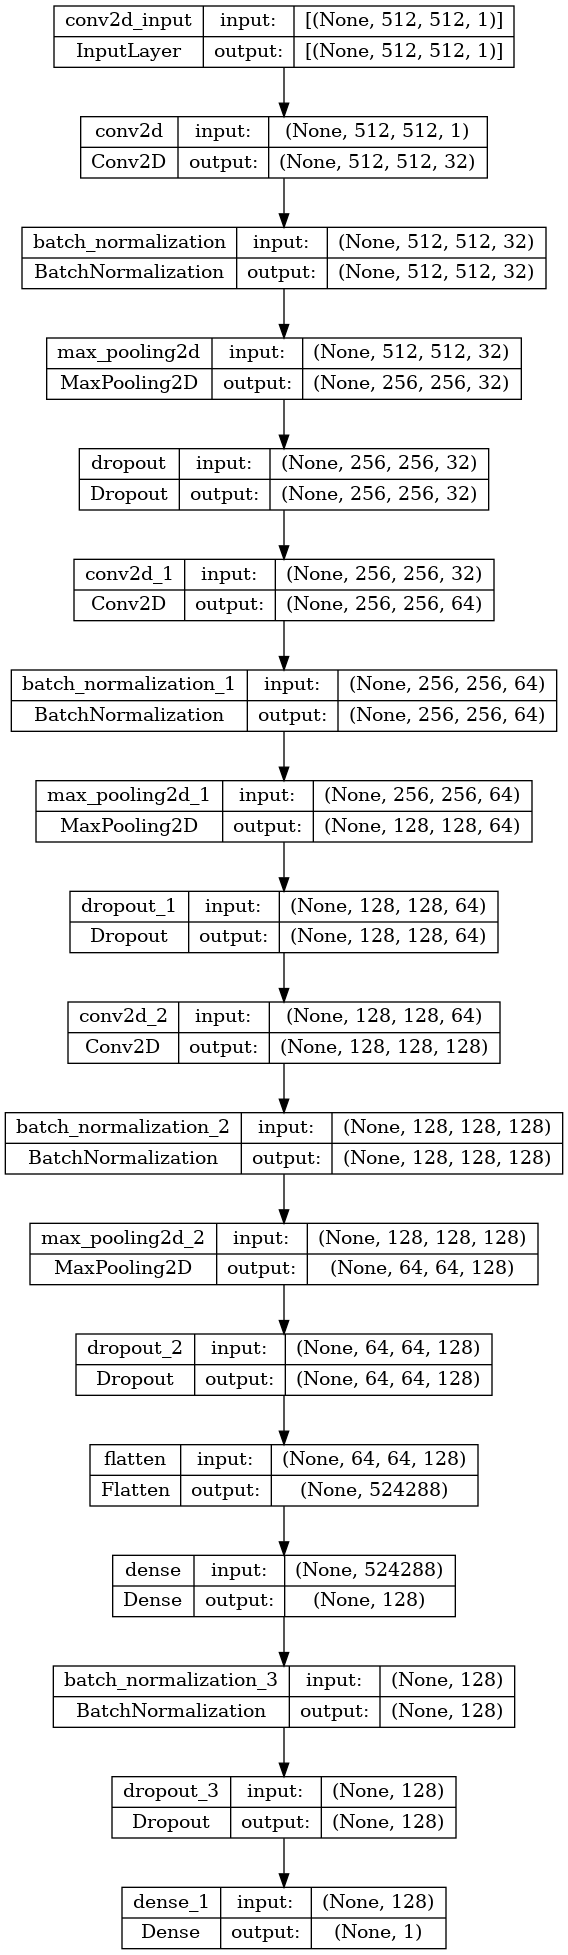

In [28]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='luna.png', show_shapes=True,show_layer_names=True)
Image(filename='luna.png')